In [4]:
#importing all the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# --- DBSCAN (with distance-based eps tuning) ---
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer

In [33]:
df = pd.read_csv("./dataset/DM1_game_dataset_cleaned.csv")

# Select numeric columns and drop missing values
df_num = df.select_dtypes(include=['float64', 'int64'])
numeric_cols = [col for col in df_num.columns if df_num[col].nunique() > 2]  # exclude binary columns
df_num = df_num[numeric_cols]

# exclude BGGId
df_num = df_num.drop(columns=['BGGId'], errors='ignore')


X = df_num.values

print(f"Data shape: {X.shape}, Features: {df_num.columns.tolist()}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data shape: (21925, 18), Features: ['YearPublished', 'GameWeight', 'NumWish', 'MfgPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'Rank:strategygames', 'Rank:abstracts', 'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames', 'Rank:partygames', 'Rank:childrensgames', 'Players']


## 1. K-Means

In [34]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
kmeans.fit(X_scaled)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

In [36]:
# labels
labels = kmeans.labels_
labels

array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [37]:
# centroids
centroids = kmeans.cluster_centers_
centroids

array([[ 9.80599625e-02,  8.27714411e-01,  2.47172614e-01,
         1.38891316e-01,  7.32638932e-01,  1.67278909e-01,
        -6.13635518e-02,  1.74057836e-01,  8.99513016e-02,
         3.55130670e-01, -1.71154290e-01, -2.11164249e-01,
         2.13450948e-01,  4.40523459e-02,  4.86637830e-01,
        -1.18137452e-01, -1.75539676e-01, -9.31208092e-02],
       [ 9.50573760e-02, -6.16116724e-01, -1.81872270e-01,
        -1.02691326e-01, -5.39773699e-01, -1.24474255e-01,
         6.77217853e-03, -1.28383341e-01, -6.39464637e-02,
        -2.62564705e-01,  1.14162293e-01,  1.60342202e-01,
        -1.56863506e-01, -3.12961955e-02, -3.61193773e-01,
         8.87924868e-02,  1.22344522e-01,  6.88643745e-02],
       [-9.29211628e+00, -3.79241961e-01, -2.29515600e-01,
        -1.01808288e-01, -6.42329065e-01, -7.89173010e-02,
         2.16889154e+00, -1.44581468e-01, -2.06822278e-01,
        -2.60662674e-01,  8.06859944e-01, -7.71429787e-02,
        -2.08988046e-01, -1.02424956e-01, -2.80168136e

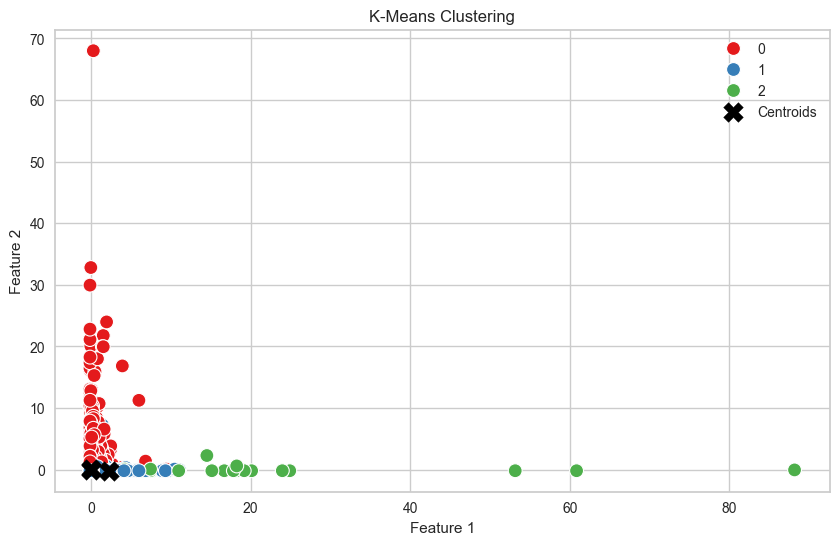

In [51]:
# plotting the clusters
plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_scaled[:, 6], y=X_scaled[:, 7], hue=labels, palette='Set1', s=100)
plt.scatter(centroids[:, 6], centroids[:, 7], c='black', s=200, marker='X', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

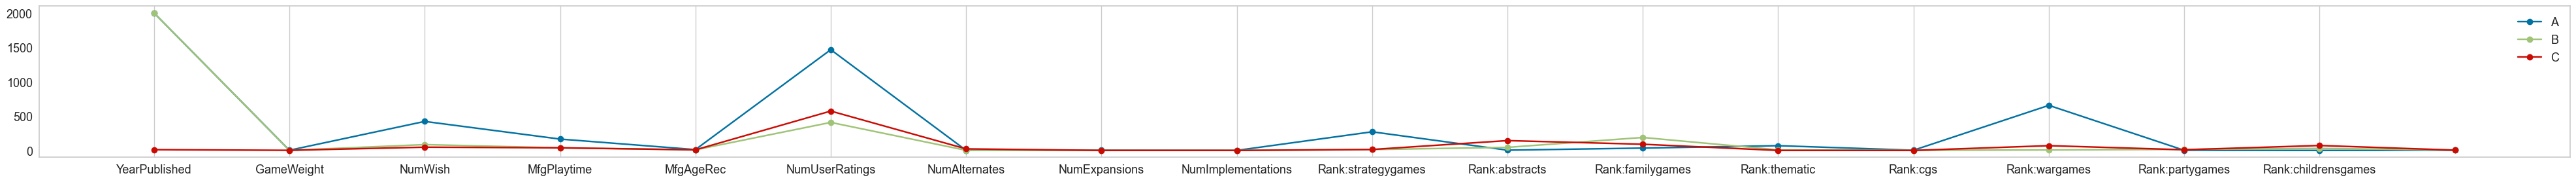

In [39]:
plt.figure(figsize=(50, 3))

centers = scaler.inverse_transform(centroids)

clust_name = ['A', 'B', 'C']

for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])

plt.xticks(range(0,len(df_num.columns) - 1), df_num.columns[:-1], fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

In [24]:
# SSE and silhouette score
sse = kmeans.inertia_
print(f'SSE: {sse:.4f}')

sil_score = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {sil_score:.4f}')

SSE: 342846.4368
Silhouette Score: 0.1851


In [26]:
%%time
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state = 42)
    kmeans.fit(X_scaled)
    sse_list.append(kmeans.inertia_)

CPU times: total: 6min 23s
Wall time: 1min 3s


In [28]:
%%time
sil_list = []
dist = squareform(pdist(X_scaled)) # using a precomputed distance matrix

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_scaled)
    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

CPU times: total: 11min 13s
Wall time: 5min 59s


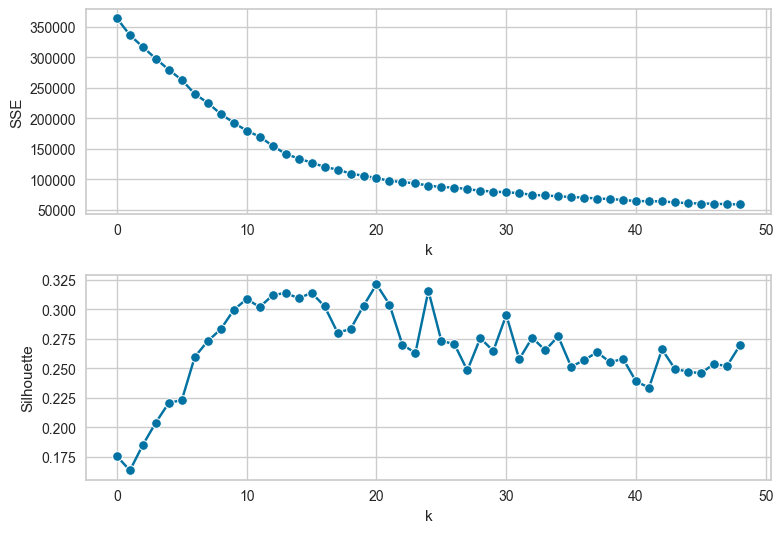

In [29]:
fig, axs = plt.subplots(2)

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots
plt.show()

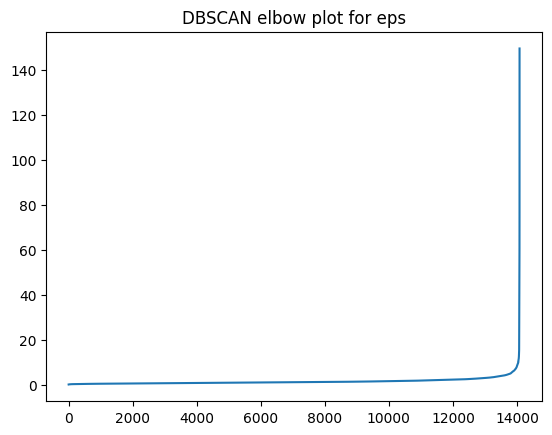

Silhouette (DBSCAN): -0.4755984717875862
{np.int64(-1): np.int64(12591), np.int64(0): np.int64(560), np.int64(1): np.int64(120), np.int64(2): np.int64(256), np.int64(3): np.int64(49), np.int64(4): np.int64(9), np.int64(5): np.int64(70), np.int64(6): np.int64(12), np.int64(7): np.int64(27), np.int64(8): np.int64(51), np.int64(9): np.int64(21), np.int64(10): np.int64(5), np.int64(11): np.int64(10), np.int64(12): np.int64(31), np.int64(13): np.int64(6), np.int64(14): np.int64(5), np.int64(15): np.int64(9), np.int64(16): np.int64(27), np.int64(17): np.int64(10), np.int64(18): np.int64(11), np.int64(19): np.int64(5), np.int64(20): np.int64(9), np.int64(21): np.int64(17), np.int64(22): np.int64(8), np.int64(23): np.int64(5), np.int64(24): np.int64(6), np.int64(25): np.int64(11), np.int64(26): np.int64(7), np.int64(27): np.int64(10), np.int64(28): np.int64(11), np.int64(29): np.int64(4), np.int64(30): np.int64(5), np.int64(31): np.int64(8), np.int64(32): np.int64(6), np.int64(33): np.int64(5)

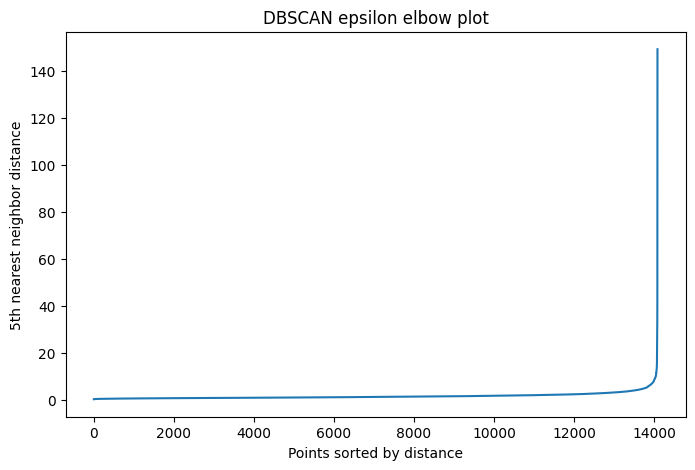

eps=8.388 | clusters=2 | noise=0.36%
Silhouette: 0.443


KeyboardInterrupt: 

In [5]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


df = pd.read_csv("./dataset/DM1_game_dataset.csv")
# Select numeric columns and drop missing values
df_num = df.select_dtypes(include=['float64', 'int64']).dropna()

# Scale features (as in the DM1 slides)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4])
plt.plot(distances)
plt.title("DBSCAN elbow plot for eps")
plt.show()

# Example model
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
print("Silhouette (DBSCAN):", silhouette_score(X_scaled, db.labels_))

unique, counts = np.unique(db.labels_, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print(cluster_summary)

# Find the elbow point
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("DBSCAN epsilon elbow plot")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.show()

eps_val = distances[14000]   # value at the elbow
db = DBSCAN(eps=eps_val, min_samples=5).fit(X_scaled)

labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = list(labels).count(-1) / len(labels)

print(f"eps={eps_val:.3f} | clusters={n_clusters} | noise={noise_ratio:.2%}")

if n_clusters > 1:
    sil = silhouette_score(X_scaled, labels)
    print(f"Silhouette: {sil:.3f}")

for eps in np.linspace(eps_val*0.8, eps_val*1.2, 5):
    db = DBSCAN(eps=eps, min_samples=5).fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = list(labels).count(-1) / len(labels)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, labels)
        print(f"eps={eps:.3f} | clusters={n_clusters} | noise={noise_ratio:.1%} | silhouette={sil:.3f}")

